In [1]:
import cdms2 as cdms
import MV2 as MV
import genutil,cdutil,cdtime
from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof



import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/kmarvel/Google Drive/python-utils")
import CMIP5_tools as cmip5
import DA_tools
import Plotting 

In [6]:
f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/FIX/cmip5.sahel_precip.historical-rcp85.nc")
#Total precipitation
pr_tot=f("pr_sahel")


In [7]:
cdutil.setTimeBoundsMonthly(pr_tot)
pr_anom=cdutil.YEAR.departures(pr_tot)

/Users/kmarvel/anaconda2/envs/cdat2/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdat2/lib/python2.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


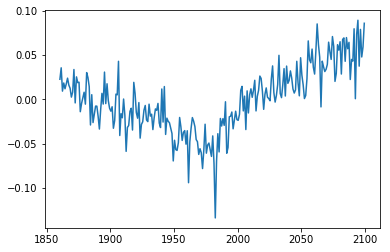

In [8]:
avg_over_ensembles=cmip5.ensemble2multimodel(pr_anom)
mma=MV.average(avg_over_ensembles,axis=0)
Plotting.time_plot(mma)

In [10]:
f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/FIX/cmip5.sahel_precip.piControl.nc")
pr_tot_piC=f("pr_sahel")
f.close()
pr_anom_piC=cdutil.YEAR.departures(pr_tot_piC)

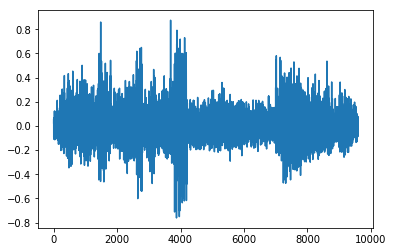

In [11]:
noise=DA_tools.concatenate_this(pr_anom_piC,compressed=False)
Plotting.time_plot(noise)

In [12]:
projections=pr_anom
def TOE(projections,noise,starttime=None,L_init=30):
    nmod,nyears=projections.shape
    
    
    if starttime is None:
        starttime=cdtime.comptime(2000,1,1)
    endtime=starttime.add(L_init,cdtime.Years)
    y2100=cdtime.comptime(2100,1,1)
    yrs=2100-endtime.year+1
    SN=MV.zeros((nmod,yrs))
    
    counter=0
    while endtime.cmp(y2100)<=0:
        trunc=projections(time=(starttime,endtime))
        L=trunc.shape[1]
        signals=cmip5.get_linear_trends(trunc)
        
        slopes=DA_tools.get_slopes(noise,L)
        SN[:,counter]=signals/np.std(slopes)
        endtime=endtime.add(1,cdtime.Years)
        counter+=1
    SN.setAxis(0,projections.getAxis(0))
    tax=cdms.createAxis(np.arange(yrs)+starttime.year+L_init)
    tax.designateTime()
    tax.id="time"
    tax.units='years since 0001-1-1'
    SN.setAxis(1,tax)
    return SN
    

In [13]:
SN=TOE(projections,noise,L_init=30)

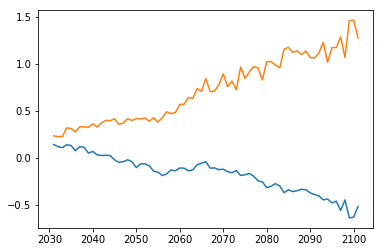

In [16]:
Plotting.time_plot(MV.average(SN,axis=0))
Plotting.time_plot(MV.average(cmip5.ensemble2multimodel(SN),axis=0))

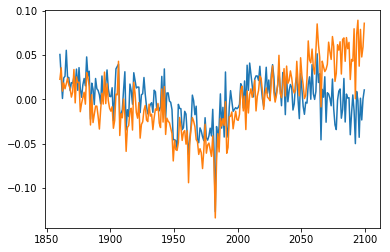

In [17]:
Plotting.time_plot(MV.average(projections,axis=0))
Plotting.time_plot(MV.average(cmip5.ensemble2multimodel(projections),axis=0))